In [1]:
# increase cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import pandas as pd
import numpy as np
import gc
import os
import time
import pickle

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [5]:
from tensorflow.python.keras.models import load_model

In [6]:
cal_fire_s2_stacked_df = pd.read_csv('../Data/Processed/WildFire_S2Cells_stacked.csv')
cal_fire_s2_stacked_df[cal_fire_s2_stacked_df.FIRE_CUSTOM_ID=='CAMP_2018_11_08_0'].shape

(93, 16)

In [7]:
cal_fire_s2_stacked_df[cal_fire_s2_stacked_df.FIRE_CUSTOM_ID=='CAMP_2018_11_08_0'].head()

,FIRE_CUSTOM_ID,S2_Cells_ID,FZ_grp,AGENCY,UNIT_ID,CAUSE,GIS_ACRES,C_METHOD,OBJECTIVE,Shape_Length,Shape_Area,YEAR,ALARM_DATE_DT_DT,CONT_DATE_DT_DT,FIRE_DUR,ALARM_DATE_MONTH
1196,CAMP_2018_11_08_0,808334,low,CDF,BTU,11.0,153335.5625,1.0,1.0,311935.278756,6.205270e+08,2018,2018-11-08,2018-11-26,19.0,11
1197,CAMP_2018_11_08_0,809ccc,low,CDF,BTU,11.0,153335.5625,1.0,1.0,311935.278756,6.205270e+08,2018,2018-11-08,2018-11-26,19.0,11
1198,CAMP_2018_11_08_0,8082d4,low,CDF,BTU,11.0,153335.5625,1.0,1.0,311935.278756,6.205270e+08,2018,2018-11-08,2018-11-26,19.0,11
1199,CAMP_2018_11_08_0,80832c,low,CDF,BTU,11.0,153335.5625,1.0,1.0,311935.278756,6.205270e+08,2018,2018-11-08,2018-11-26,19.0,11
1200,CAMP_2018_11_08_0,809cc4,low,CDF,BTU,11.0,153335.5625,1.0,1.0,311935.278756,6.205270e+08,2018,2018-11-08,2018-11-26,19.0,11


In [8]:
camp_ids = cal_fire_s2_stacked_df[cal_fire_s2_stacked_df.FIRE_CUSTOM_ID=='CAMP_2018_11_08_0'][['S2_Cells_ID', 'ALARM_DATE_DT_DT', 'FZ_grp']]
camp_ids.columns = ['s2_cell_id', 'measure_date', 'FZ_grp']
camp_ids.head()

,s2_cell_id,measure_date,FZ_grp
1196,808334,2018-11-08,low
1197,809ccc,2018-11-08,low
1198,8082d4,2018-11-08,low
1199,80832c,2018-11-08,low
1200,809cc4,2018-11-08,low


In [9]:
camp_ids.FZ_grp.value_counts()

high    65
med     20
low      8
Name: FZ_grp, dtype: int64

In [10]:
def split_train_test(data, features):
    indexer = data[['s2_cell_id','measure_date']].copy()
    train = data[data.measure_date < '2018-01-01'].copy()
    test = data[data.measure_date >= '2018-01-01'].copy()
    
    y_train = train.wf_wildfire.copy().values
    y_test = test.wf_wildfire.copy().values    
    
    train = train[features]
    test = test[features]    
    
    test_ids = data[data.measure_date >= '2018-01-01'][['s2_cell_id', 'measure_date']]
    
    return train, test, y_train, y_test, test_ids

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          cmap=plt.cm.Blues):
    """
    Source: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py

    Prints and plots the confusion matrix.

    Args:
        y_true: list of true target labels
        y_pred: list of predicted target labels
        classes: tuple of class labels in 0, 1 order

    Kwargs:
        normalize: bool, normalize confusion matrix or not
        cmap: color map
    """

    if normalize:
        title = 'Normalized confusion matrix'
    else:
        title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    print('Confusion matrix, without normalization')
    print(cm)

    print(classification_report(y_true, y_pred, target_names=classes))

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes,
           yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(),
             rotation=45,
             ha="right",
             rotation_mode="anchor")

    # loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()
    
def bin_prob(probs, y_test):
    y_binned = np.digitize(probs, np.arange(0,1.1,0.1))
    bin_df = pd.DataFrame(list(zip(y_test, probs, y_binned)), columns =['Actual', 'Prob', 'Bin'])
    bin_df = bin_df.groupby('Bin').agg({'Actual': ['mean', 'sum', 'count'], 'Prob': 'mean'})
    return bin_df

In [11]:
scaler = MinMaxScaler()

In [14]:
tl_features = [
    'tl_object_id',
    'tl_kv_sort_sum'
]

wf_features = [
    'wf_count_1yr_ago',
    'wf_count_2yr_ago',
    'wf_count_3yr_ago',
    'wf_count_4yr_ago',
    'wf_count_5yr_ago'
]

sat_features = [
 'sat_faparval_min',
 'sat_faparval_max',
 'sat_faparval_mean',
#  'sat_faparval_median',
 'sat_faparval_std',
 'sat_faparval_size',
 'sat_faparval_count',
 'sat_faparval',
 'sat_faparmask_min',
 'sat_faparmask_max',
 'sat_faparmask_mean',
#  'sat_faparmask_median',
 'sat_faparmask_std',
 'sat_faparmask_size'
]

wea_features = [
 'wea_air_temp_max',
 'wea_air_temp_mean',
 'wea_precip_accum_max',
 'relative_humidity_max',
 'relative_humidity_min',
 'relative_humidity_mean',
 'wea_wind_speed_max',
 'wea_wind_speed_min',
 'wea_wind_speed_mean',
 'wind_gust_max',
 'wea_air_temp_mean_ma7',
 'wea_precip_accum_max_ma7',
 'relative_humidity_mean_ma7',
 'wea_air_temp_mean_l1',
 'wea_precip_accum_max_l1',
 'relative_humidity_mean_l1'
]

new_features = [
 'fuel_percent_ma7',
 'fuel_percent_ma30',
 'fuel_percent_l1',
 'wea_air_temp_mean_ma30',
 'wea_precip_accum_max_ma30',
 'relative_humidity_mean_ma30'
]

In [13]:
final_df = pd.read_csv('./consolidated_4_10pct_sample.csv')
final_df.shape

(1169778, 163)

In [15]:
gc.collect()
feature_cols = wea_features + tl_features + sat_features + ['fuel_percent'] + new_features

# train, _, _, _, _ = split_train_test(final_df, feature_cols)
# train_sc = scaler.fit_transform(train)

# pickle.dump(scaler, open('scaler_10pct_noprecip', 'wb'))
# pickle.dump(scaler, open('scaler_10pct_precip', 'wb'))

/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [16]:
# del final_df, train, train_sc
# gc.collect()

28

In [17]:
# scaler = pickle.load(open('scaler_10pct_noprecip', 'rb'))
scaler = pickle.load(open('scaler_10pct_precip', 'rb'))

In [18]:
test_df = pd.read_csv('./consolidated_4_2018.csv')
test_df.shape

(3884695, 40)

In [19]:
cuts = list(range(0, test_df.shape[0], test_df.shape[0]//10+1))
cuts[-1] = test_df.shape[0]+1
test_sc = np.empty([0,len(feature_cols)])
for i in range(len(cuts[:-1])):
    print("Cut: {}".format(cuts[i]))
    temp = test_df[cuts[i]:cuts[i+1]][feature_cols]  
    temp = scaler.transform(temp)
    test_sc = np.append(test_sc, temp, axis=0)
test_sc.shape

Cut: 0
Cut: 388470
Cut: 776940
Cut: 1165410
Cut: 1553880
Cut: 1942350
Cut: 2330820
Cut: 2719290
Cut: 3107760


(3884695, 37)

In [20]:
y_test = test_df.wf_wildfire.copy().values    
test_ids = test_df[['s2_cell_id', 'measure_date']]

In [82]:
camp_test = test_ids.merge(camp_ids, on=['s2_cell_id','measure_date'], how='left', indicator=True)
camp_test._merge.value_counts()

left_only     3884635
both               60
right_only          0
Name: _merge, dtype: int64

In [83]:
camp_test.FZ_grp.value_counts()

high    43
med     17
Name: FZ_grp, dtype: int64

In [80]:
model_mlp_adam_noprecip_cw2000 = load_model('./Models/mlp_adam_noprecip_cw2000.h5')
mlp_adam_noprecip_cw2000_probs = model_mlp_adam_noprecip_cw2000.predict(test_sc)
bin_prob(mlp_adam_noprecip_cw2000_probs[:,0], y_test)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


Actual                      Prob
         mean    sum    count      mean
Bin                                    
1    0.000000    0.0   221488  0.043684
2    0.000024    8.0   340119  0.155309
3    0.000027   14.0   525706  0.251326
4    0.000078   48.0   611688  0.351673
5    0.000322  296.0   918564  0.455320
6    0.000640  744.0  1163192  0.540110
7    0.001340  128.0    95531  0.632828
8    0.000493    4.0     8117  0.725496
9    0.000000    0.0       50  0.815680
10   0.000000    0.0      227  0.993513
11   0.000000    0.0       13  1.000000

Confusion matrix, without normalization
[[2617200 1266253]
 [    366     876]]
              precision    recall  f1-score   support

         nwf       1.00      0.67      0.81   3883453
          wf       0.00      0.71      0.00      1242

   micro avg       0.67      0.67      0.67   3884695
   macro avg       0.50      0.69      0.40   3884695
weighted avg       1.00      0.67      0.80   3884695



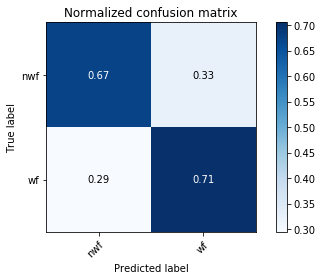

In [81]:
mlp_adam_noprecip_cw2000_preds = mlp_adam_noprecip_cw2000_probs[:,0]>0.5
plot_confusion_matrix(y_test, mlp_adam_noprecip_cw2000_preds, ['nwf', 'wf'], normalize=True)

In [109]:
with open('./Models/mlp_adam_noprecip_cw2000_probs.csv', 'w') as filename:
    filename.write('S2_Cells_ID'+','+'DATE_DT_DT'+'Probability'+'\n')
    for i in range(test_ids.shape[0]):
        filename.write(test_ids.loc[i,'s2_cell_id']+','+test_ids.loc[i,'measure_date']+','+str(mlp_adam_noprecip_cw2000_probs[i,0])+'\n')

In [85]:
model_mlp_adam_noprecip_cwEQ_ext = load_model('./Models/mlp_adam_noprecip_cwEQ_ext.h5')
mlp_adam_noprecip_cwEQ_ext_probs = model_mlp_adam_noprecip_cwEQ_ext.predict(test_sc)
bin_prob(mlp_adam_noprecip_cwEQ_ext_probs[:,0], y_test)

Actual                     Prob
         mean    sum   count      mean
Bin                                   
1    0.000033   11.0  328627  0.049124
2    0.000129   41.0  317874  0.150651
3    0.000180   76.0  422740  0.253352
4    0.000220  126.0  571944  0.351901
5    0.000308  221.0  717028  0.451193
6    0.000471  330.0  701012  0.549198
7    0.000550  305.0  555030  0.645163
8    0.000496  120.0  241796  0.739809
9    0.000425   12.0   28222  0.822002
10   0.000000    0.0     160  0.960350
11   0.000000    0.0     262  1.000000

Confusion matrix, without normalization
[[2357738 1525715]
 [    475     767]]
              precision    recall  f1-score   support

         nwf       1.00      0.61      0.76   3883453
          wf       0.00      0.62      0.00      1242

   micro avg       0.61      0.61      0.61   3884695
   macro avg       0.50      0.61      0.38   3884695
weighted avg       1.00      0.61      0.76   3884695



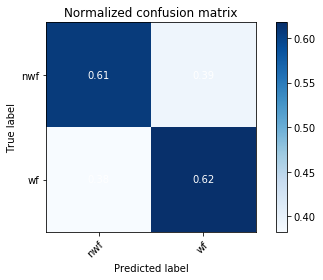

In [86]:
mlp_adam_noprecip_cwEQ_ext_preds = mlp_adam_noprecip_cwEQ_ext_probs[:,0]>0.5
plot_confusion_matrix(y_test, mlp_adam_noprecip_cwEQ_ext_preds, ['nwf', 'wf'], normalize=True)

In [22]:
camp_preds = pd.DataFrame(mlp_adam_noprecip_cw2000_probs[camp_test._merge=='both'][:,0])
camp_preds.columns = ['mlp_adam_noprecip_cw2000_probs']
temp = pd.DataFrame(mlp_adam_noprecip_cwEQ_ext_probs[camp_test._merge=='both'][:,0])
temp.columns = ['mlp_adam_noprecip_cwEQ_ext_probs']
camp_preds = camp_preds.join(temp)
camp_preds.head()

,mlp_adam_noprecip_cw2000_probs,mlp_adam_noprecip_cwEQ_ext_probs
0,0.563708,0.556569
1,0.564941,0.702367
2,0.644757,0.703734
3,0.638986,0.773011
4,0.556674,0.581052


In [99]:
gc.collect()

0

In [110]:
with open('./Models/mlp_adam_noprecip_cwEQ_ext_probs.csv', 'w') as filename:
    filename.write('S2_Cells_ID'+','+'DATE_DT_DT'+'Probability'+'\n')
    for i in range(test_ids.shape[0]):
        filename.write(test_ids.loc[i,'s2_cell_id']+','+test_ids.loc[i,'measure_date']+','+str(mlp_adam_noprecip_cwEQ_ext_probs[i,0])+'\n')

In [21]:
model_mlp_adam_precip_cw2000 = load_model('./Models/mlp_adam_precip_cw2000.h5')
mlp_adam_precip_cw2000_probs = model_mlp_adam_precip_cw2000.predict(test_sc)
bin_prob(mlp_adam_precip_cw2000_probs[:,0], y_test)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


Actual                      Prob
         mean    sum    count      mean
Bin                                    
1    0.000019    5.0   268093  0.046255
2    0.000020    8.0   392586  0.155129
3    0.000031   16.0   522348  0.251185
4    0.000113   71.0   629948  0.351982
5    0.000267  243.0   910109  0.454017
6    0.000749  797.0  1063718  0.542578
7    0.001103   94.0    85259  0.629044
8    0.000946    7.0     7403  0.729186
9    0.000980    1.0     1020  0.850707
10   0.000000    0.0     3360  0.971250
11   0.000000    0.0      851  1.000000

Confusion matrix, without normalization
[[2722741 1160712]
 [    343     899]]
              precision    recall  f1-score   support

         nwf       1.00      0.70      0.82   3883453
          wf       0.00      0.72      0.00      1242

   micro avg       0.70      0.70      0.70   3884695
   macro avg       0.50      0.71      0.41   3884695
weighted avg       1.00      0.70      0.82   3884695



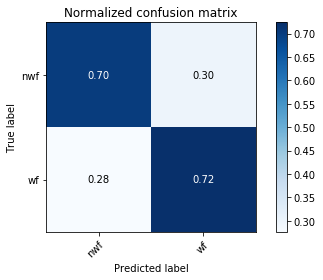

In [22]:
mlp_adam_precip_cw2000_preds = mlp_adam_precip_cw2000_probs[:,0]>0.5
plot_confusion_matrix(y_test, mlp_adam_precip_cw2000_preds, ['nwf', 'wf'], normalize=True)

In [23]:
with open('./Models/mlp_adam_precip_cw2000_probs.csv', 'w') as filename:
    filename.write('S2_Cells_ID'+','+'DATE_DT_DT'+'Probability'+'\n')
    for i in range(test_ids.shape[0]):
        filename.write(test_ids.loc[i,'s2_cell_id']+','+test_ids.loc[i,'measure_date']+','+str(mlp_adam_precip_cw2000_probs[i,0])+'\n')

In [24]:
model_mlp_adam_precip_cwEQ_ext = load_model('./Models/mlp_adam_precip_cwEQ_ext.h5')
mlp_adam_precip_cwEQ_ext_probs = model_mlp_adam_precip_cwEQ_ext.predict(test_sc)
bin_prob(mlp_adam_precip_cwEQ_ext_probs[:,0], y_test)

Actual                     Prob
         mean    sum   count      mean
Bin                                   
1    0.000028    9.0  325680  0.050929
2    0.000089   31.0  348988  0.151056
3    0.000174   71.0  407070  0.251365
4    0.000259  121.0  467963  0.351045
5    0.000339  187.0  551902  0.451630
6    0.000537  333.0  620249  0.549628
7    0.000517  285.0  550944  0.648980
8    0.000391  147.0  375756  0.746389
9    0.000247   52.0  210173  0.841193
10   0.000233    6.0   25784  0.922932
11   0.000000    0.0     186  1.000000

Confusion matrix, without normalization
[[2101184 1782269]
 [    419     823]]
              precision    recall  f1-score   support

         nwf       1.00      0.54      0.70   3883453
          wf       0.00      0.66      0.00      1242

   micro avg       0.54      0.54      0.54   3884695
   macro avg       0.50      0.60      0.35   3884695
weighted avg       1.00      0.54      0.70   3884695



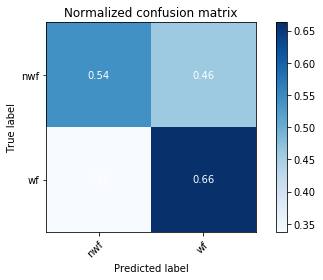

In [25]:
mlp_adam_precip_cwEQ_ext_preds = mlp_adam_precip_cwEQ_ext_probs[:,0]>0.5
plot_confusion_matrix(y_test, mlp_adam_precip_cwEQ_ext_preds, ['nwf', 'wf'], normalize=True)

In [27]:
with open('./Models/mlp_adam_precip_cwEQ_ext_probs.csv', 'w') as filename:
    filename.write('S2_Cells_ID'+','+'DATE_DT_DT'+'Probability'+'\n')
    for i in range(test_ids.shape[0]):
        filename.write(test_ids.loc[i,'s2_cell_id']+','+test_ids.loc[i,'measure_date']+','+str(mlp_adam_precip_cwEQ_ext_probs[i,0])+'\n')

In [26]:
camp_test = test_ids.merge(camp_ids, on=['s2_cell_id','measure_date'], how='left', indicator=True)
camp_preds = pd.DataFrame(mlp_adam_precip_cw2000_probs[camp_test._merge=='both'][:,0])
camp_preds.columns = ['mlp_adam_precip_cw2000_probs']
temp = pd.DataFrame(mlp_adam_precip_cwEQ_ext_probs[camp_test._merge=='both'][:,0])
temp.columns = ['mlp_adam_precip_cwEQ_ext_probs']
camp_preds = camp_preds.join(temp)
camp_preds.describe()

,mlp_adam_precip_cw2000_probs,mlp_adam_precip_cwEQ_ext_probs
count,60.000000,60.000000
mean,0.571977,0.703935
std,0.044537,0.124407
min,0.478660,0.417340
25%,0.545512,0.614692
50%,0.569716,0.699046
75%,0.600176,0.815014
max,0.661778,0.918858


In [30]:
camp_preds.describe()

,mlp_adam_noprecip_cw2000_probs,mlp_adam_noprecip_cwEQ_ext_probs,mlp_adam_precip_cw2000_probs,mlp_adam_precip_cwEQ_ext_probs
count,60.000000,60.000000,60.000000,60.000000
mean,0.576593,0.612614,0.571977,0.703935
std,0.041937,0.108984,0.044537,0.124407
min,0.491003,0.391369,0.478660,0.417340
25%,0.552228,0.524461,0.545512,0.614692
50%,0.570638,0.606153,0.569716,0.699046
75%,0.615421,0.702708,0.600176,0.815014
max,0.648034,0.822135,0.661778,0.918858


In [37]:
mlp_adam_noprecip_cw2000_probs.mean(), mlp_adam_noprecip_cw2000_probs.std() ,np.percentile(pd.Series(mlp_adam_noprecip_cw2000_probs[:,0]), 90), np.percentile(pd.Series(mlp_adam_noprecip_cw2000_probs[:,0]), 99)

(0.39251184, 0.156928, 0.5570347130298614, 0.6419803726673127)

In [38]:
mlp_adam_noprecip_cwEQ_ext_probs.mean(), mlp_adam_noprecip_cwEQ_ext_probs.std() ,np.percentile(pd.Series(mlp_adam_noprecip_cwEQ_ext_probs[:,0]), 90), np.percentile(pd.Series(mlp_adam_noprecip_cwEQ_ext_probs[:,0]), 99)

(0.4227691, 0.20021868, 0.6732831776142121, 0.7908311849832536)

In [39]:
mlp_adam_precip_cw2000_probs.mean(), mlp_adam_precip_cw2000_probs.std() ,np.percentile(pd.Series(mlp_adam_precip_cw2000_probs[:,0]), 90), np.percentile(pd.Series(mlp_adam_precip_cw2000_probs[:,0]), 99)

(0.38168582, 0.16261958, 0.5599527716636657, 0.6390063637495048)

In [40]:
mlp_adam_precip_cwEQ_ext_probs.mean(), mlp_adam_precip_cwEQ_ext_probs.std() ,np.percentile(pd.Series(mlp_adam_precip_cwEQ_ext_probs[:,0]), 90), np.percentile(pd.Series(mlp_adam_precip_cwEQ_ext_probs[:,0]), 99)

(0.45446873, 0.22992793, 0.7545404314994812, 0.8880939567089081)